# Классификационные модели с использованием метода машинного обучения

**Общий путь создания модели**
* Подготовка дескрипторов
* Нормализация дескрипторов
* Подбор лучших параметров с применением перекрестного скользящего контроля
* Построение итоговой модели
* Предсказание данных

In [15]:
from rdkit.Chem import Descriptors, SDMolSupplier
from collections import Counter
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import pickle
import sys
import os
from IPython.display import display
from PIL import Image

current_dir = os.getcwd() # текущая директория
# Добавляем папку utils в путь
utils_path = os.path.join(current_dir, "utils")
sys.path.append(utils_path)

from my_logger import logger
from utils import start
from descriptors import process_molecules, get_descriptors, standardize_molecules

start()

# Взгляд на данные

* Есть 4 выборки: простая обучающая выборка, cбалансированная обучающая, простая тестовая и cбалансированная тестовая выборка.

In [3]:
def vizualization_data(file_path, save_path="./data/img"):
    """
    """
    os.makedirs(save_path, exist_ok=True)
    data = [mol for mol in SDMolSupplier(file_path) if mol is not None]

    activity_values = [mol.GetProp("Activity") for mol in data if mol.HasProp("Activity")]
    activity_counts = Counter(activity_values)

    plt.figure(figsize=(6, 5))
    plt.bar(activity_counts.keys(), activity_counts.values(), color=['purple', "green"], alpha=0.5)
    plt.xlabel('Activity', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.title('Distribution of Activity', fontsize=14)
    plt.tight_layout()

    file_name = os.path.splitext(os.path.basename(file_path))[0]
    print(f"Количество данных в {file_name}:", len(data))
    
    output_file = os.path.join(save_path, f"{file_name}.png")
    plt.savefig(output_file, dpi=300)
    plt.close()
    features, transformer = get_descriptors(data)
    return  data, features, transformer

In [4]:
# смотрим на стандартизированные данные
molecules_train, train, train_transformer = vizualization_data("./data/train.sdf")
molecules_train_balanced, train_balanced, train_balanced_transformer = vizualization_data("./data/train_balanced_correct.sdf")

molecules_test, test, test_transformer = vizualization_data("./data/test.sdf")
molecules_test_balanced, test_balanced, test_balanced_transformer = vizualization_data("./data/test_balanced_correct.sdf")

Количество данных в train: 2474


[19:06:14] Running Uncharger
[19:06:14] Initializing MetalDisconnector
[19:06:14] Running MetalDisconnector
[19:06:14] Initializing Normalizer
[19:06:14] Running Normalizer
[19:06:14] Running LargestFragmentChooser
[19:06:14] Initializing MetalDisconnector
[19:06:14] Running MetalDisconnector
[19:06:14] Running Uncharger
[19:06:14] Initializing MetalDisconnector
[19:06:14] Running MetalDisconnector
[19:06:14] Initializing Normalizer
[19:06:14] Running Normalizer
[19:06:14] Running LargestFragmentChooser
[19:06:14] Initializing MetalDisconnector
[19:06:14] Running MetalDisconnector
[19:06:14] Running Uncharger
[19:06:14] Initializing MetalDisconnector
[19:06:14] Running MetalDisconnector
[19:06:14] Initializing Normalizer
[19:06:14] Running Normalizer
[19:06:14] Running LargestFragmentChooser
[19:06:14] Initializing MetalDisconnector
[19:06:14] Running MetalDisconnector
[19:06:14] Running Uncharger
[19:06:14] Removed negative charge.
[19:06:14] Initializing MetalDisconnector
[19:06:14] 

[19:06:14] Initializing MetalDisconnector
[19:06:14] Running MetalDisconnector
[19:06:14] Running Uncharger
[19:06:14] Initializing MetalDisconnector
[19:06:14] Running MetalDisconnector
[19:06:14] Initializing Normalizer
[19:06:14] Running Normalizer
[19:06:14] Running LargestFragmentChooser
[19:06:14] Initializing MetalDisconnector
[19:06:14] Running MetalDisconnector
[19:06:14] Running Uncharger
[19:06:14] Initializing MetalDisconnector
[19:06:14] Running MetalDisconnector
[19:06:14] Initializing Normalizer
[19:06:14] Running Normalizer
[19:06:14] Running LargestFragmentChooser
[19:06:14] Initializing MetalDisconnector
[19:06:14] Running MetalDisconnector
[19:06:14] Running Uncharger
[19:06:14] Removed positive charge.
[19:06:14] Initializing MetalDisconnector
[19:06:14] Running MetalDisconnector
[19:06:14] Initializing Normalizer
[19:06:14] Running Normalizer
[19:06:14] Running LargestFragmentChooser
[19:06:14] Initializing MetalDisconnector
[19:06:14] Running MetalDisconnector
[19

Количество данных в train_balanced_correct: 770


[19:06:47] Running Uncharger
[19:06:47] Initializing MetalDisconnector
[19:06:47] Running MetalDisconnector
[19:06:47] Initializing Normalizer
[19:06:47] Running Normalizer
[19:06:47] Running LargestFragmentChooser
[19:06:47] Initializing MetalDisconnector
[19:06:47] Running MetalDisconnector
[19:06:47] Running Uncharger
[19:06:47] Removed negative charge.
[19:06:47] Initializing MetalDisconnector
[19:06:47] Running MetalDisconnector
[19:06:47] Initializing Normalizer
[19:06:47] Running Normalizer
[19:06:47] Running LargestFragmentChooser
[19:06:47] Initializing MetalDisconnector
[19:06:47] Running MetalDisconnector
[19:06:47] Running Uncharger
[19:06:47] Initializing MetalDisconnector
[19:06:47] Running MetalDisconnector
[19:06:47] Initializing Normalizer
[19:06:47] Running Normalizer
[19:06:47] Running LargestFragmentChooser
[19:06:47] Initializing MetalDisconnector
[19:06:47] Running MetalDisconnector
[19:06:47] Running Uncharger
[19:06:47] Initializing MetalDisconnector
[19:06:47] 

Количество данных в test: 2474


[19:07:00] Running Uncharger
[19:07:00] Initializing MetalDisconnector
[19:07:00] Running MetalDisconnector
[19:07:00] Initializing Normalizer
[19:07:00] Running Normalizer
[19:07:00] Running LargestFragmentChooser
[19:07:00] Initializing MetalDisconnector
[19:07:00] Running MetalDisconnector
[19:07:00] Running Uncharger
[19:07:00] Initializing MetalDisconnector
[19:07:00] Running MetalDisconnector
[19:07:00] Initializing Normalizer
[19:07:00] Running Normalizer
[19:07:00] Running LargestFragmentChooser
[19:07:00] Initializing MetalDisconnector
[19:07:00] Running MetalDisconnector
[19:07:00] Running Uncharger
[19:07:00] Initializing MetalDisconnector
[19:07:00] Running MetalDisconnector
[19:07:00] Initializing Normalizer
[19:07:00] Running Normalizer
[19:07:00] Running LargestFragmentChooser
[19:07:00] Initializing MetalDisconnector
[19:07:00] Running MetalDisconnector
[19:07:00] Running Uncharger
[19:07:00] Initializing MetalDisconnector
[19:07:00] Running MetalDisconnector
[19:07:00]

Количество данных в test_balanced_correct: 742


[19:07:33] Running Uncharger
[19:07:33] Initializing MetalDisconnector
[19:07:33] Running MetalDisconnector
[19:07:33] Initializing Normalizer
[19:07:33] Running Normalizer
[19:07:33] Running LargestFragmentChooser
[19:07:33] Initializing MetalDisconnector
[19:07:33] Running MetalDisconnector
[19:07:33] Running Uncharger
[19:07:33] Initializing MetalDisconnector
[19:07:33] Running MetalDisconnector
[19:07:33] Initializing Normalizer
[19:07:33] Running Normalizer
[19:07:33] Running LargestFragmentChooser
[19:07:33] Initializing MetalDisconnector
[19:07:33] Running MetalDisconnector
[19:07:33] Running Uncharger
[19:07:33] Initializing MetalDisconnector
[19:07:33] Running MetalDisconnector
[19:07:33] Initializing Normalizer
[19:07:33] Running Normalizer
[19:07:33] Running LargestFragmentChooser
[19:07:33] Initializing MetalDisconnector
[19:07:33] Running MetalDisconnector
[19:07:33] Running Uncharger
[19:07:33] Initializing MetalDisconnector
[19:07:33] Running MetalDisconnector
[19:07:33]

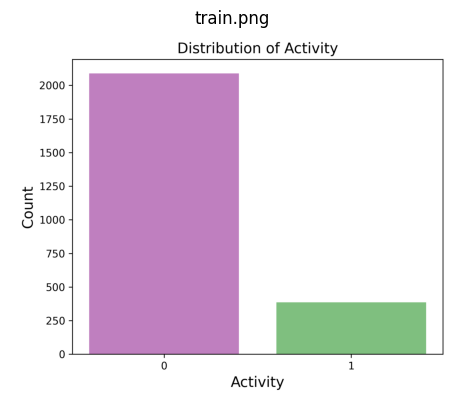

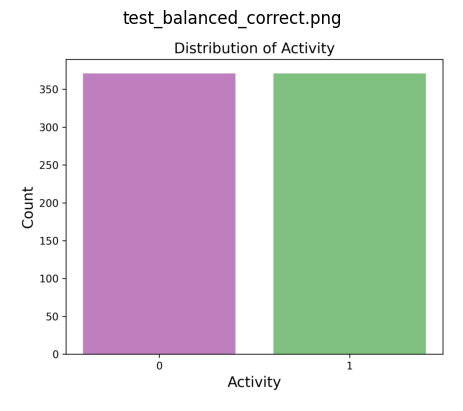

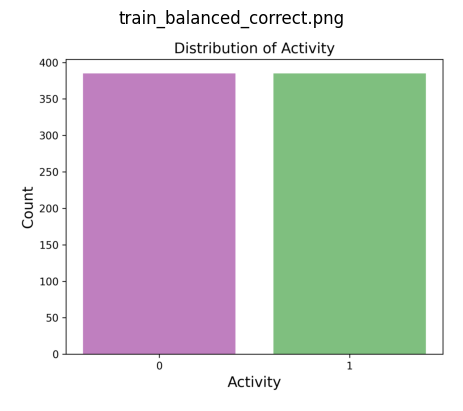

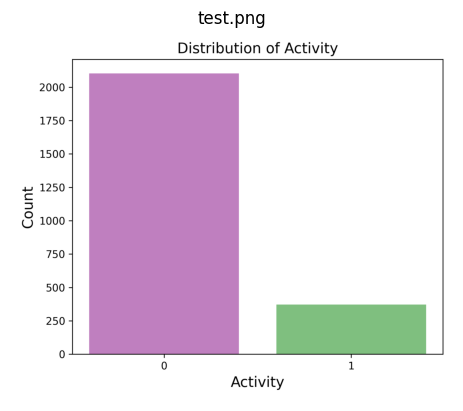

In [5]:
folder_path = "./data/img"
for file in os.listdir(folder_path):
    if file.endswith(".png"): 
        file_path = os.path.join(folder_path, file)
        img = Image.open(file_path)
        
        plt.figure()
        plt.imshow(img)
        plt.axis("off")  # убираем оси
        plt.title(file)  # добавляем название файла
        plt.show()

# Просмотр готовых данных к обучению

In [6]:
with open("./data/learning/train_balanced_min_max_transformer.pkl", 'rb') as file:
    train_balanced_min_max_transformer = pickle.load(file)
train_balanced_min_max_transformer

Pipeline(steps=[('descriptors_generation',
                 FunctionTransformer(func=<function process_molecules at 0x7f6a0c3dae80>)),
                ('normalization', MinMaxScaler())])

In [7]:
with open("./data/learning/train_standard_transformer.pkl", 'rb') as file:
    train_standard_transformer = pickle.load(file)
train_standard_transformer

Pipeline(steps=[('descriptors_generation',
                 FunctionTransformer(func=<function process_molecules at 0x7f6a0c3dae80>)),
                ('normalization', StandardScaler())])

In [8]:
train_standard_scaled = pd.read_csv("./data/learning/train_standard_scaled.csv")
train_standard_scaled

heavy_atom_count  nhoh_count  no_count  num_h_acceptors  num_h_donors  num_heteroatoms  num_rotatable_bonds  num_valence_electrons  num_aromatic_rings  num_Aliphatic_heterocycles  ring_count  full_molecular_weight   log_p  molecular_refractivity    tspa  balaban_j
0              -0.6870     -1.2882   -1.1952          -0.6711       -1.3754          -0.4196              -1.3816                -0.6700             -0.3852                    0.6612       -0.0721                -0.3703  0.2547                 -0.4407 -1.5468    -0.4726
1               0.4032     -0.2714    0.5972           1.0545       -0.1385           0.6516               1.7419                 0.3049              0.7266                   -0.8720       -0.0721                 0.3720 -0.4609                  0.3966  0.2821    -1.1048
2               1.2753     -0.2714    1.1947           1.0545       -0.1385           0.6516               1.7419                 1.1985              0.7266                   -0.8720       -0.0721                 0.9778 -0.1162                  1.1403  1.0608    -0.8381
3              -1.3411     -0.2714   -1.1952          -0.6711       -0.1385          -0.9552               1.2213                -1.1574             -1.4970                   -0.8720       -2.2678                -1.1596  0.0525                 -1.2252 -0.5294     2.4829
4               0.4032     -0.2714   -0.0002          -0.6711       -0.1385          -0.4196               1.7419                 0.7111             -1.4970                    0.6612       -1.1700                 0.2663 -0.0150                  0.4491 -0.3404     0.7943
...                ...         ...       ...              ...           ...              ...                  ...                    ...                 ...                       ...           ...                    ...     ...                     ...     ...        ...
2460           -0.2509     -1.2882    0.5972           1.0545       -1.3754           1.1873              -0.8610                -0.5075              1.8384                   -0.8720        1.0257                -0.2297 -0.3273                 -0.6876 -0.0553    -0.0301
2461            1.0573     -0.2714   -0.0002           0.4793       -0.1385           0.1160               0.7007                 0.9548              0.7266                    0.6612        1.0257                 0.9788  1.1232                  1.3133 -0.1035    -0.7664
2462            0.8392      0.7454    1.1947          -0.0959        1.0984           1.1873               1.7419                 0.9548             -0.3852                    0.6612       -0.0721                 0.9388 -1.3839                  0.7954  1.2711    -1.0833
2463            0.6212     -0.2714   -0.5977          -0.6711       -0.1385          -0.4196               0.7007                 0.7111             -0.3852                   -0.8720       -0.0721                 0.6305  1.6662                  0.9259 -0.7490    -0.5874
2464            0.8392     -0.2714    0.5972          -0.6711       -0.1385           0.1160               0.7007                 0.7923             -0.3852                    2.1944        1.0257                 0.5535 -0.2956                  0.5914 -0.1969    -1.6132

In [9]:
test_standard_scaled = pd.read_csv("./data/learning/test_standard_scaled.csv")
test_standard_scaled

heavy_atom_count  nhoh_count  no_count  num_h_acceptors  num_h_donors  num_heteroatoms  num_rotatable_bonds  num_valence_electrons  num_aromatic_rings  num_Aliphatic_heterocycles  ring_count  full_molecular_weight   log_p  molecular_refractivity    tspa  balaban_j
0              -1.9579     -1.2746   -2.2565          -0.6456       -1.3454          -1.4209              -1.3620                -1.9269             -0.3884                   -0.8586       -1.1457                -1.5960  1.0704                 -1.5293 -2.5461     1.9500
1              -1.3113     -0.2302   -0.5464          -0.6456       -0.0974          -0.3864              -1.3620                -1.3656             -0.3884                   -0.8586       -1.1457                -1.2017 -0.7971                 -1.3359 -0.4546     2.1892
2               0.1977      0.8142    1.1637           1.0487        1.1505           0.6481              -0.3368                -0.0825              1.8096                   -0.8586        1.0008                -0.1438 -0.1219                 -0.0742  0.9675    -0.5766
3              -1.3113     -0.2302   -1.6864          -1.2104       -0.0974          -1.4209               0.1757                -1.3656             -0.3884                   -0.8586       -1.1457                -1.2816  0.3927                 -0.9741 -1.3780    -0.3233
4              -1.5268     -1.2746   -1.1164          -0.6456       -1.3454          -1.4209              -1.8745                -1.5259             -0.3884                   -0.8586       -1.1457                -1.6873 -0.8745                 -1.5599 -1.1131     3.1146
...                ...         ...       ...              ...           ...              ...                  ...                    ...                 ...                       ...           ...                    ...     ...                     ...     ...        ...
2454            0.6288     -0.2302    0.5937          -0.0808       -0.0974           0.6481               0.6883                 0.8797             -1.4874                    0.6548       -0.0725                 0.7568 -0.3005                  0.4669  0.7538    -0.3600
2455           -0.2334     -1.2746   -0.5464          -0.0808       -1.3454          -0.3864               0.1757                -0.3231              0.7106                   -0.8586       -0.0725                -0.2328  0.7216                 -0.3292 -0.5721     0.2908
2456            1.4911      0.8142    1.1637           0.4839        1.1505           0.6481               0.1757                 1.2807              1.8096                   -0.8586        1.0008                 1.1156  0.0765                  1.4419  0.9780    -1.1888
2457           -1.5268     -0.2302   -2.2565          -1.7751       -0.0974          -1.9382              -0.3368                -1.5259             -0.3884                   -0.8586       -1.1457                -1.4762  0.4737                 -1.1993 -1.9190    -0.0188
2458           -0.4490     -0.2302    0.0236           0.4839       -0.0974           0.1308              -0.8494                -0.4033             -0.3884                    0.6548       -0.0725                -0.3824 -0.1968                 -0.3413 -0.3135    -0.4737

# Pipeline 

In [10]:
# Возьмем случайный pipeline
with open("./tree_clsf/models/TreeClsfNonSamplStdSc.pkl", 'rb') as file:
    pipeline = pickle.load(file)
pipeline

Pipeline(steps=[('scaler',
                 Pipeline(steps=[('descriptors_generation',
                                  FunctionTransformer(func=<function process_molecules at 0x7f6a0c3dae80>)),
                                 ('normalization', StandardScaler())])),
                ('model', DecisionTreeClassifier(max_depth=np.int64(60)))])

# Результаты

In [11]:
folders = ['logregr', 'tree_clsf', 'forest_clsf', 'knn_clsf']

for folder in folders:
    if os.path.exists(folder) and os.path.isdir(folder):
        target_file = f"{folder}/{folder}.csv"
        if os.path.exists(target_file):
            print(f"{folder}")
            display(pd.read_csv(target_file))

logregr


model size_x_test    balance_activity_train    balance_activity_test  balanced_accuracy    f1   auc  mean_time_fit_s_cv  mean_time_predict_s_cv  size_model_pipeline_mb  mean_ram_fit_mb  grade                    params
0   LogRegrNonSamplMinMaxSc      49.94%   {(0,): 2087, (1,): 378}  {(0,): 2101, (1,): 358}               0.86  0.90  0.94                0.73                     0.0                     0.0             1.45   True  {'C': np.int64(10), '...
1      LogRegrSMOTEMinMaxSc      49.94%  {(0,): 2087, (1,): 2087}  {(0,): 2101, (1,): 358}               0.84  0.77  0.94                1.58                     0.0                     0.0             1.74  False  {'C': np.int64(70), '...
2  LogRegrUnderSamplMinM...      49.94%    {(0,): 378, (1,): 378}  {(0,): 2101, (1,): 358}               0.82  0.74  0.94                0.28                     0.0                     0.0             1.84  False  {'C': np.int64(50), '...
3  LogRegrSMOTETomekMinM...      49.94%  {(0,): 2086, (1,): 2086}  {(0,): 2101, (1,): 358}               0.84  0.77  0.94                1.67                     0.0                     0.0             1.85  False  {'C': np.int64(70), '...
4  LogRegrMyLocalBalance...      48.86%    {(0,): 385, (1,): 378}   {(0,): 371, (1,): 358}               0.83  0.82  0.94                0.02                     0.0                     0.0             1.85  False  {'C': np.int64(110), ...
5      LogRegrNonSamplStdSc      49.94%   {(0,): 2087, (1,): 378}  {(0,): 2101, (1,): 358}               0.80  0.91  0.95                0.04                     0.0                     0.0             1.85  False  {'C': np.int64(70), '...
6         LogRegrSMOTEStdSc      49.94%  {(0,): 2087, (1,): 2087}  {(0,): 2101, (1,): 358}               0.88  0.89  0.95                0.06                     0.0                     0.0             1.86   True  {'C': np.int64(100), ...
7    LogRegrUnderSamplStdSc      49.94%    {(0,): 378, (1,): 378}  {(0,): 2101, (1,): 358}               0.88  0.87  0.95                0.08                     0.0                     0.0             1.86   True  {'C': np.int64(10), '...
8    LogRegrSMOTETomekStdSc      49.94%  {(0,): 2086, (1,): 2086}  {(0,): 2101, (1,): 358}               0.88  0.89  0.95                0.06                     0.0                     0.0             1.88   True  {'C': np.int64(30), '...
9  LogRegrMyLocalBalance...      48.86%    {(0,): 385, (1,): 378}   {(0,): 371, (1,): 358}               0.86  0.86  0.94                0.08                     0.0                     0.0             1.87   True  {'C': np.int64(20), '...

tree_clsf


model size_x_test    balance_activity_train    balance_activity_test  balanced_accuracy    f1   auc  mean_time_fit_s_cv  mean_time_predict_s_cv  size_model_pipeline_mb  mean_ram_fit_mb  grade                    params
0  TreeClsfNonSamplMinMaxSc      49.94%   {(0,): 2087, (1,): 378}  {(0,): 2101, (1,): 358}               0.77  0.89  0.77                0.05                     0.0                    0.03            19.48  False  {'max_depth': np.int6...
1     TreeClsfSMOTEMinMaxSc      49.94%  {(0,): 2087, (1,): 2087}  {(0,): 2101, (1,): 358}               0.83  0.89  0.83                0.08                     0.0                    0.03            23.69  False  {'max_depth': np.int6...
2  TreeClsfUnderSamplMin...      49.94%    {(0,): 378, (1,): 378}  {(0,): 2101, (1,): 358}               0.82  0.84  0.82                0.01                     0.0                    0.01            22.54  False  {'max_depth': np.int6...
3  TreeClsfSMOTETomekMin...      49.94%  {(0,): 2086, (1,): 2086}  {(0,): 2101, (1,): 358}               0.83  0.89  0.83                0.08                     0.0                    0.03            25.24  False  {'max_depth': np.int6...
4  TreeClsfMyLocalBalanc...      48.86%    {(0,): 385, (1,): 378}   {(0,): 371, (1,): 358}               0.75  0.75  0.75                0.01                     0.0                    0.02            25.27  False  {'max_depth': np.int6...
5     TreeClsfNonSamplStdSc      49.94%   {(0,): 2087, (1,): 378}  {(0,): 2101, (1,): 358}               0.83  0.92  0.83                0.04                     0.0                    0.03            22.79  False  {'max_depth': np.int6...
6        TreeClsfSMOTEStdSc      49.94%  {(0,): 2087, (1,): 2087}  {(0,): 2101, (1,): 358}               0.84  0.86  0.84                0.08                     0.0                    0.03            23.11  False  {'max_depth': np.int6...
7   TreeClsfUnderSamplStdSc      49.94%    {(0,): 378, (1,): 378}  {(0,): 2101, (1,): 358}               0.84  0.85  0.84                0.01                     0.0                    0.01            23.00  False  {'max_depth': np.int6...
8   TreeClsfSMOTETomekStdSc      49.94%  {(0,): 2086, (1,): 2086}  {(0,): 2101, (1,): 358}               0.83  0.86  0.83                0.08                     0.0                    0.03            23.18  False  {'max_depth': np.int6...
9  TreeClsfMyLocalBalanc...      48.86%    {(0,): 385, (1,): 378}   {(0,): 371, (1,): 358}               0.81  0.81  0.81                0.01                     0.0                    0.02            25.90  False  {'max_depth': np.int6...

forest_clsf


model size_x_test    balance_activity_train    balance_activity_test  balanced_accuracy    f1   auc  mean_time_fit_s_cv  mean_time_predict_s_cv  size_model_pipeline_mb  mean_ram_fit_mb  grade                    params
0  ForestClsfNonSamplMin...      49.94%   {(0,): 2087, (1,): 378}  {(0,): 2101, (1,): 358}               0.81  0.92  0.95                0.30                    0.01                    1.27             9.04  False  {'max_depth': np.int6...
1   ForestClsfSMOTEMinMaxSc      49.94%  {(0,): 2087, (1,): 2087}  {(0,): 2101, (1,): 358}               0.86  0.92  0.94                0.53                    0.01                    1.60            10.94   True  {'max_depth': np.int6...
2  ForestClsfUnderSamplM...      49.94%    {(0,): 378, (1,): 378}  {(0,): 2101, (1,): 358}               0.87  0.88  0.94                0.16                    0.00                    0.58            11.57   True  {'max_depth': np.int6...
3  ForestClsfSMOTETomekM...      49.94%  {(0,): 2086, (1,): 2086}  {(0,): 2101, (1,): 358}               0.85  0.92  0.95                0.53                    0.01                    2.10            11.60   True  {'max_depth': np.int6...
4  ForestClsfMyLocalBala...      48.86%    {(0,): 385, (1,): 378}   {(0,): 371, (1,): 358}               0.85  0.85  0.93                0.24                    0.01                    1.09            11.61   True  {'max_depth': np.int6...
5   ForestClsfNonSamplStdSc      49.94%   {(0,): 2087, (1,): 378}  {(0,): 2101, (1,): 358}               0.84  0.94  0.96                0.53                    0.01                    2.39            11.61  False  {'max_depth': np.int6...
6      ForestClsfSMOTEStdSc      49.94%  {(0,): 2087, (1,): 2087}  {(0,): 2101, (1,): 358}               0.86  0.88  0.93                0.64                    0.01                    2.14            11.65   True  {'max_depth': np.int6...
7  ForestClsfUnderSamplS...      49.94%    {(0,): 378, (1,): 378}  {(0,): 2101, (1,): 358}               0.87  0.89  0.95                0.27                    0.01                    1.15            11.66   True  {'max_depth': np.int6...
8  ForestClsfSMOTETomekS...      49.94%  {(0,): 2086, (1,): 2086}  {(0,): 2101, (1,): 358}               0.86  0.89  0.93                0.60                    0.01                    2.66            11.74   True  {'max_depth': np.int6...
9  ForestClsfMyLocalBala...      48.86%    {(0,): 385, (1,): 378}   {(0,): 371, (1,): 358}               0.88  0.88  0.94                0.28                    0.01                    1.29            11.83   True  {'max_depth': np.int6...

knn_clsf


model size_x_test    balance_activity_train    balance_activity_test  balanced_accuracy    f1   auc  mean_time_fit_s_cv  mean_time_predict_s_cv  size_model_pipeline_mb  mean_ram_fit_mb  grade                    params
0   KNNClsfNonSamplMinMaxSc      49.94%   {(0,): 2087, (1,): 378}  {(0,): 2101, (1,): 358}               0.83  0.91  0.92                 0.0                    0.01                    0.32            14.02  False  {'metric': 'manhattan...
1      KNNClsfSMOTEMinMaxSc      49.94%  {(0,): 2087, (1,): 2087}  {(0,): 2101, (1,): 358}               0.86  0.88  0.91                 0.0                    0.02                    0.54            14.75   True  {'metric': 'manhattan...
2  KNNClsfUnderSamplMinM...      49.94%    {(0,): 378, (1,): 378}  {(0,): 2101, (1,): 358}               0.85  0.83  0.93                 0.0                    0.01                    0.10            15.03  False  {'metric': 'manhattan...
3  KNNClsfSMOTETomekMinM...      49.94%  {(0,): 2086, (1,): 2086}  {(0,): 2101, (1,): 358}               0.86  0.88  0.91                 0.0                    0.02                    0.54            15.64   True  {'metric': 'manhattan...
4  KNNClsfMyLocalBalance...      48.86%    {(0,): 385, (1,): 378}   {(0,): 371, (1,): 358}               0.85  0.85  0.91                 0.0                    0.00                    0.10            14.91   True  {'metric': 'euclidean...
5      KNNClsfNonSamplStdSc      49.94%   {(0,): 2087, (1,): 378}  {(0,): 2101, (1,): 358}               0.85  0.93  0.92                 0.0                    0.01                    0.32            15.14   True  {'metric': 'manhattan...
6         KNNClsfSMOTEStdSc      49.94%  {(0,): 2087, (1,): 2087}  {(0,): 2101, (1,): 358}               0.88  0.90  0.92                 0.0                    0.02                    0.54            15.26   True  {'metric': 'manhattan...
7    KNNClsfUnderSamplStdSc      49.94%    {(0,): 378, (1,): 378}  {(0,): 2101, (1,): 358}               0.86  0.84  0.94                 0.0                    0.01                    0.10            15.39  False  {'metric': 'manhattan...
8    KNNClsfSMOTETomekStdSc      49.94%  {(0,): 2086, (1,): 2086}  {(0,): 2101, (1,): 358}               0.88  0.90  0.92                 0.0                    0.02                    0.54            16.09   True  {'metric': 'manhattan...
9  KNNClsfMyLocalBalance...      48.86%    {(0,): 385, (1,): 378}   {(0,): 371, (1,): 358}               0.84  0.84  0.92                 0.0                    0.01                    0.10            15.80  False  {'metric': 'euclidean...

-------

## Логистическая регрессия

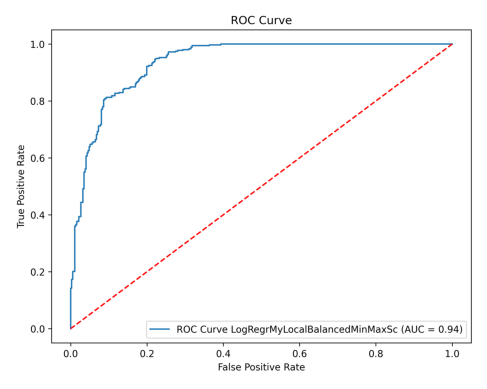

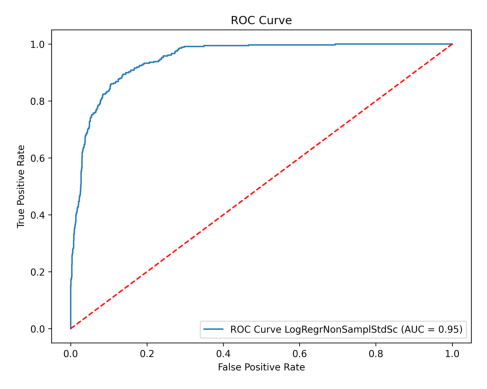

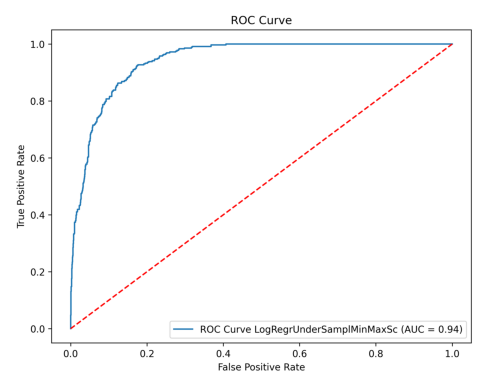

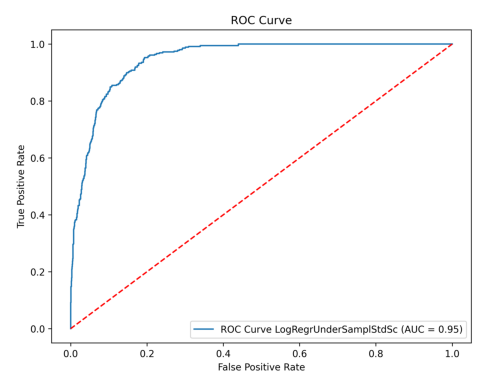

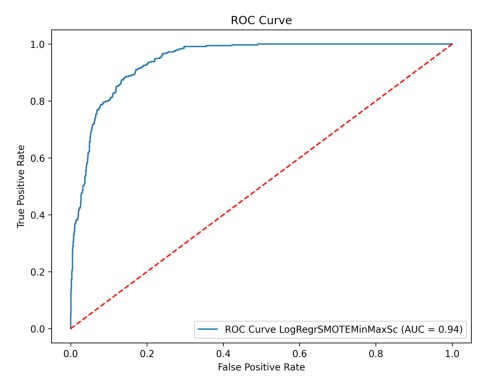

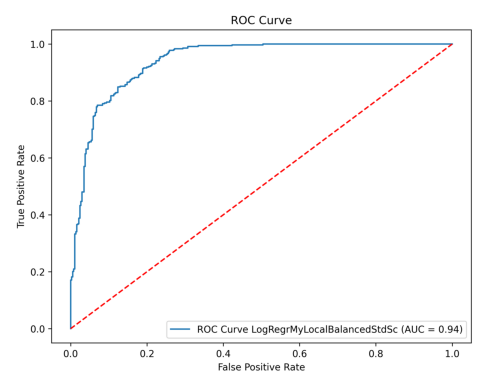

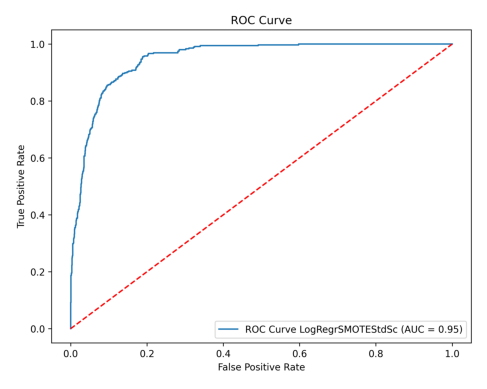

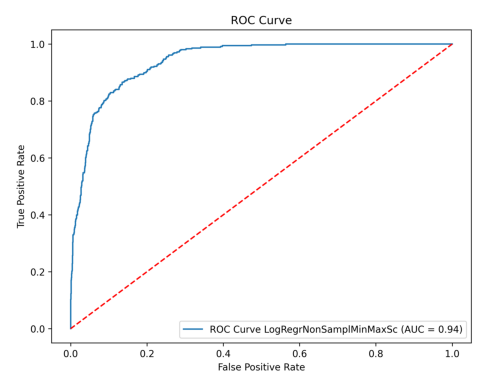

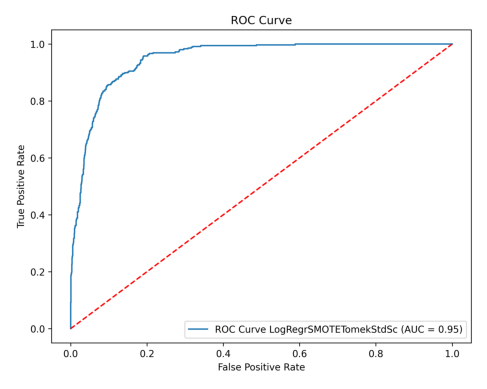

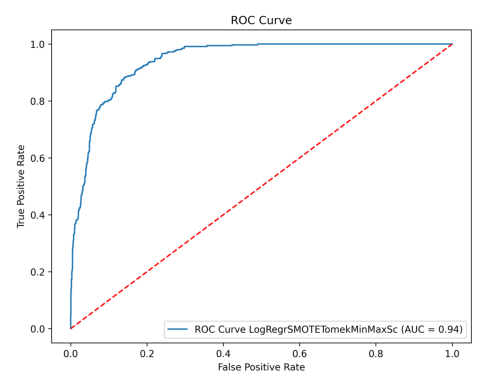

In [ ]:
folder = "./logregr/roc"
png_files = [f for f in os.listdir(folder) if f.endswith(".png")]

for file in png_files:
    img = Image.open(f"{folder}/{file}").convert("RGBA")
    
    plt.imshow(img)
    plt.axis("off")
    plt.show()

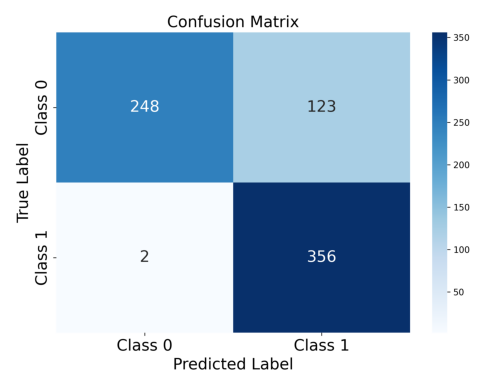

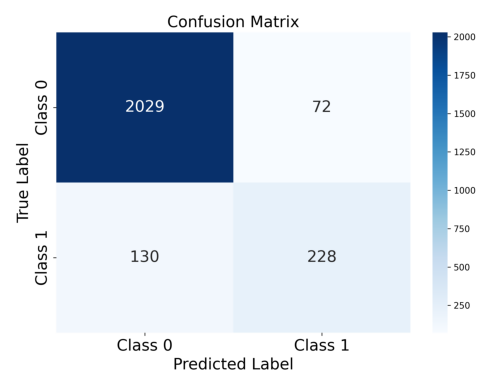

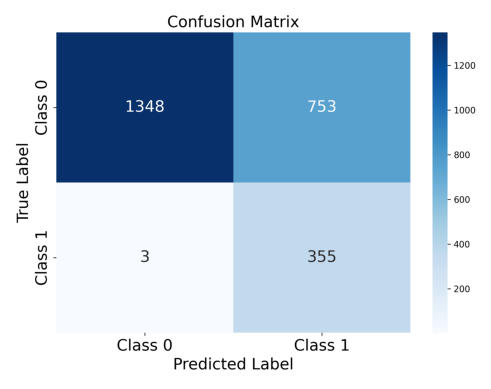

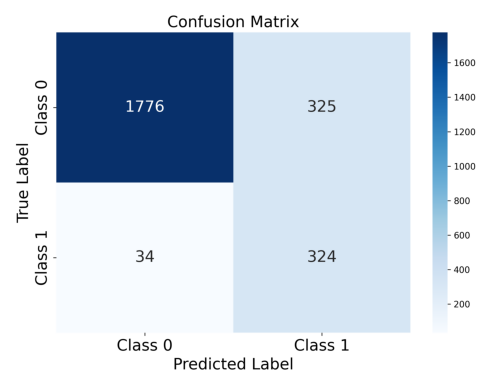

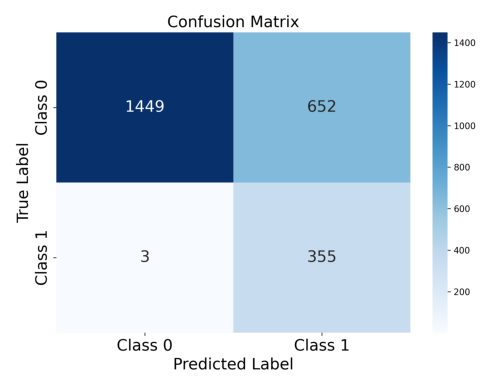

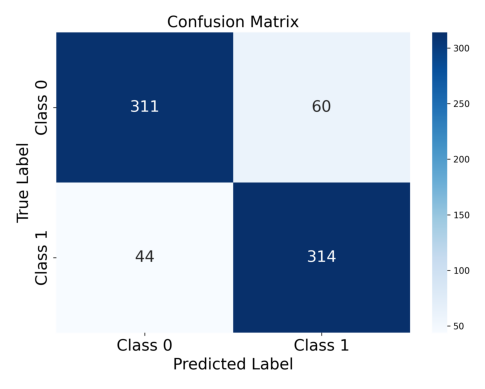

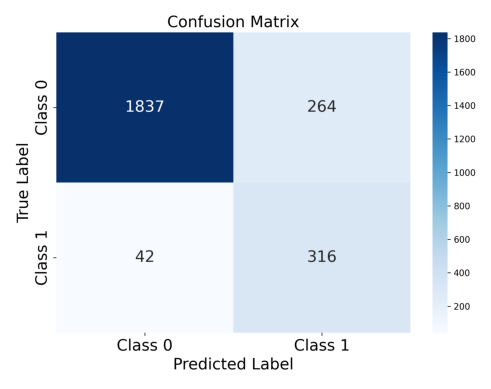

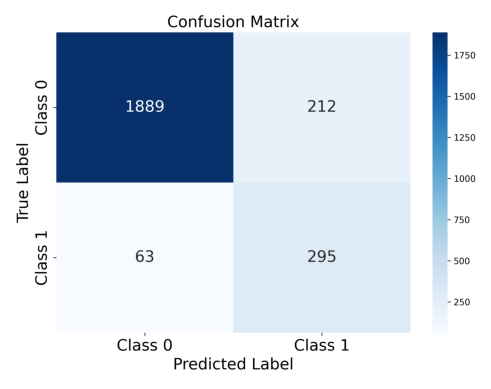

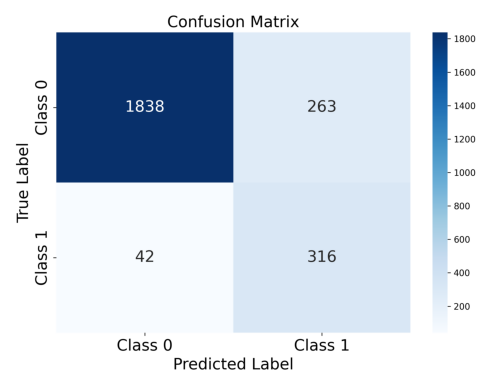

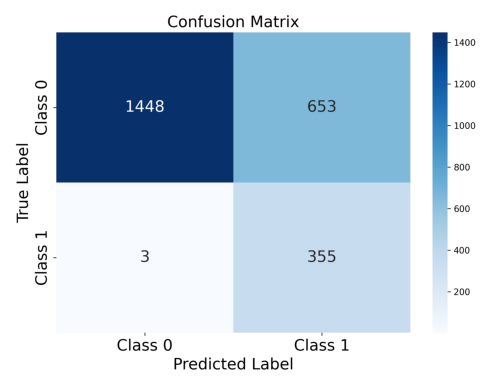

In [20]:
folder = "./logregr/matrix"
png_files = [f for f in os.listdir(folder) if f.endswith(".png")]

for file in png_files:
    img = Image.open(f"{folder}/{file}").convert("RGBA")
    
    plt.imshow(img)
    plt.axis("off") 
    plt.show()

----

## Дерево принятий решений

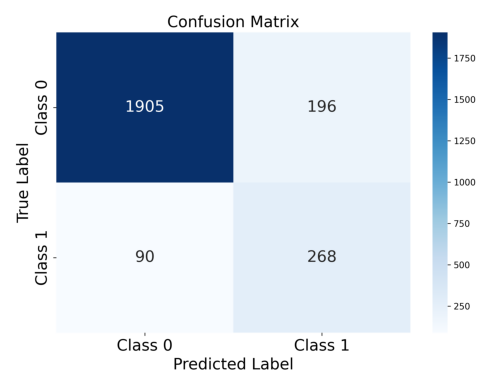

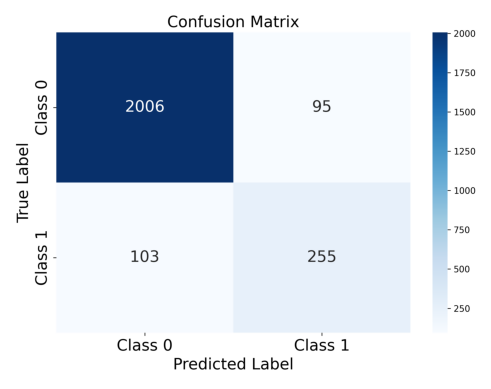

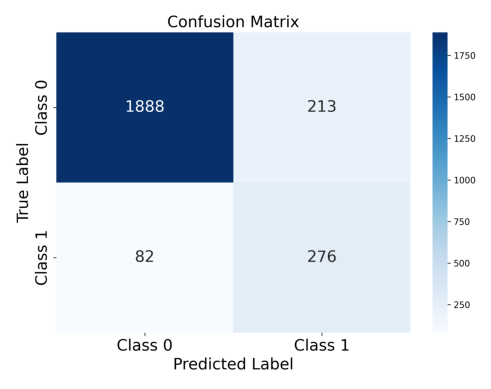

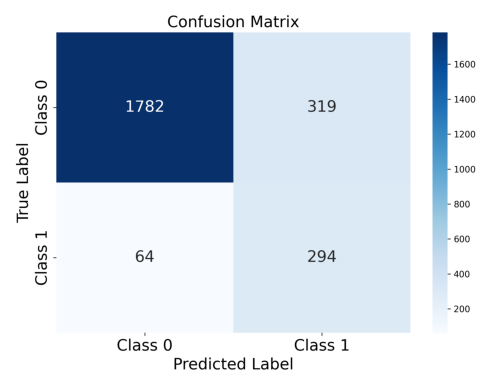

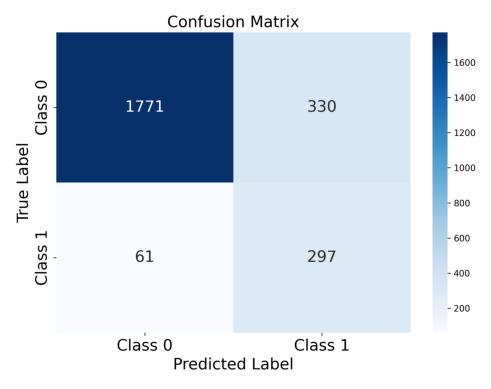

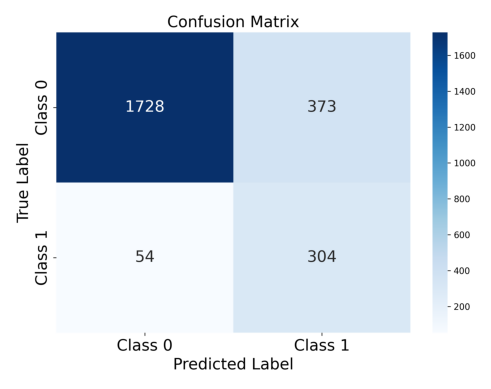

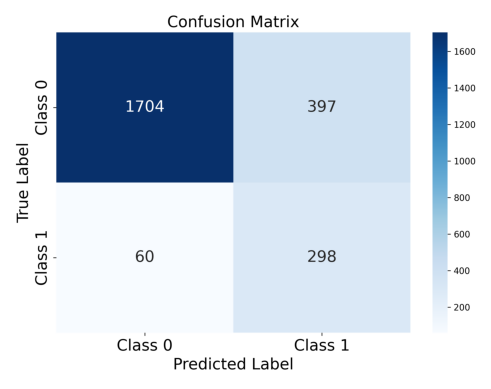

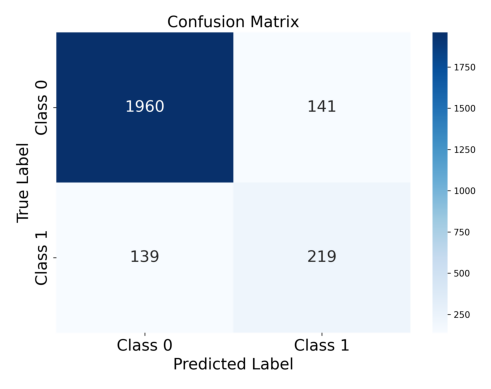

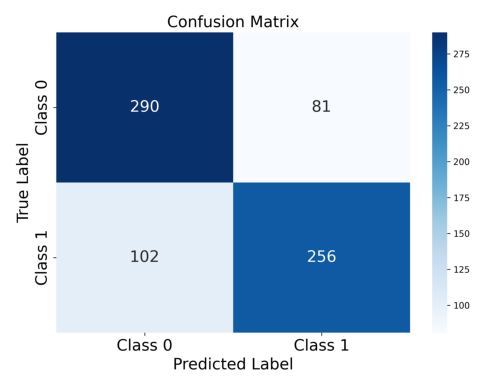

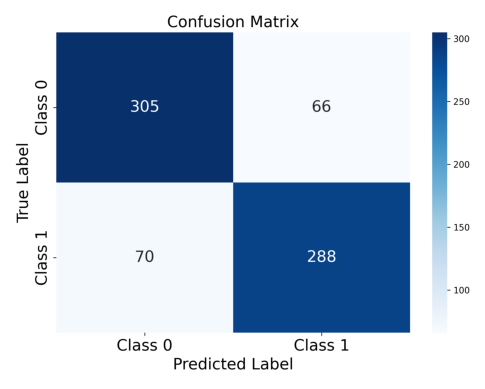

In [21]:
folder = "./tree_clsf/matrix"
png_files = [f for f in os.listdir(folder) if f.endswith(".png")]

for file in png_files:
    img = Image.open(f"{folder}/{file}").convert("RGBA")
    
    plt.imshow(img)
    plt.axis("off") 
    plt.show()

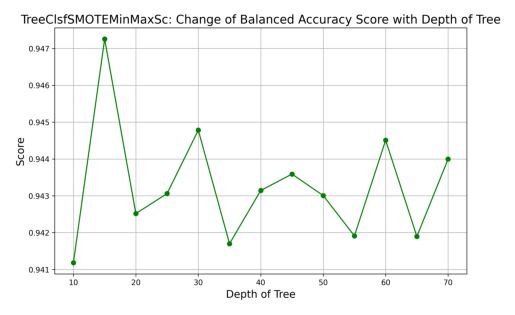

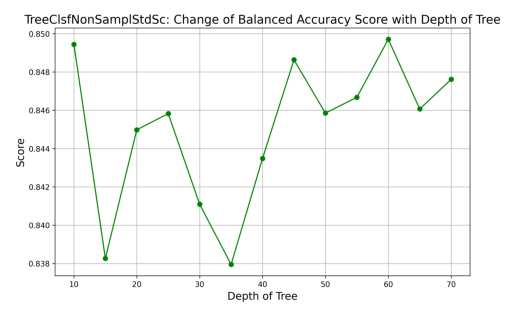

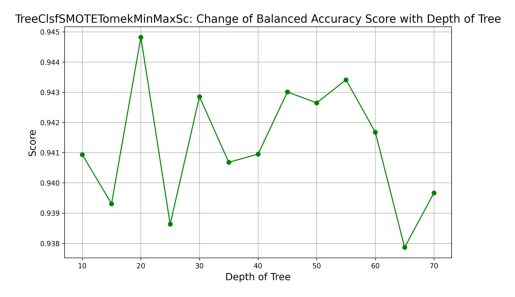

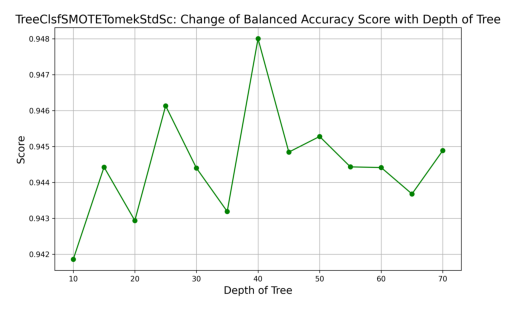

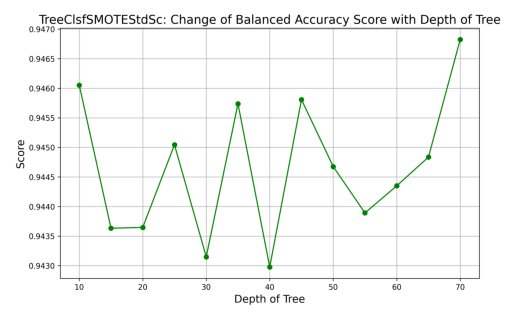

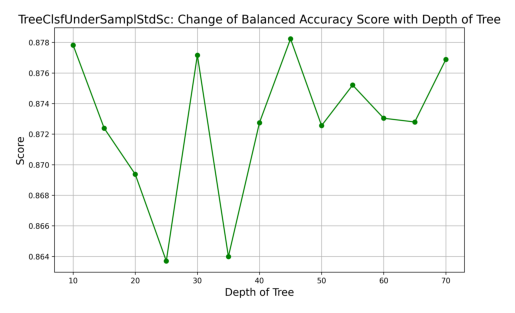

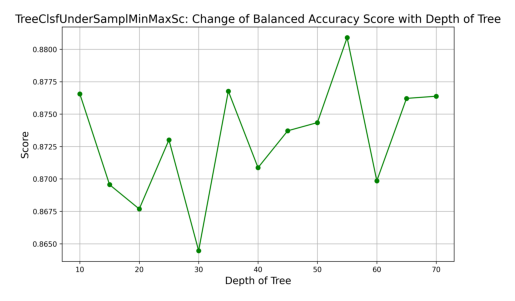

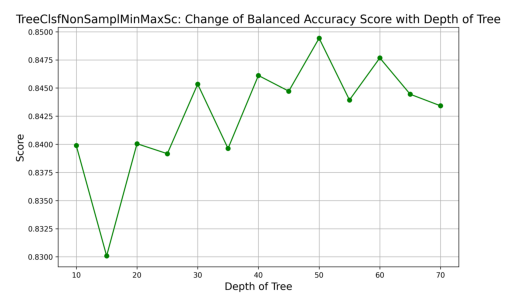

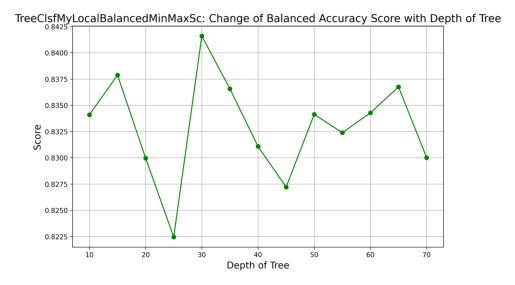

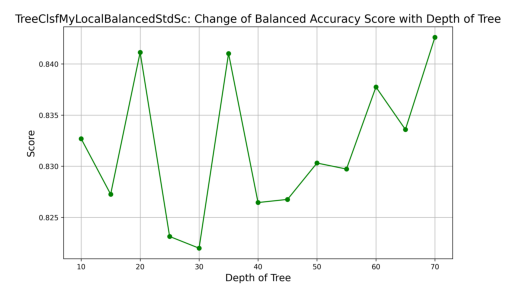

In [25]:
folder = "./tree_clsf/depth"
png_files = [f for f in os.listdir(folder) if f.endswith(".png")]

for file in png_files:
    img = Image.open(f"{folder}/{file}").convert("RGBA")
    
    plt.imshow(img)
    plt.axis("off") 
    plt.show()

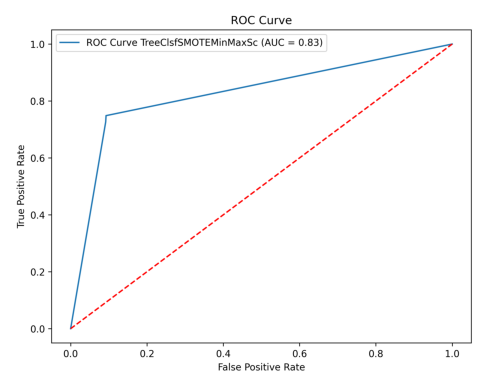

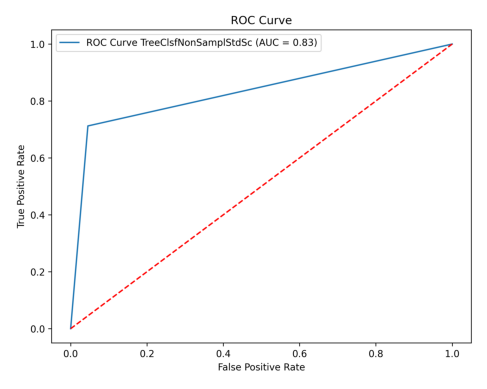

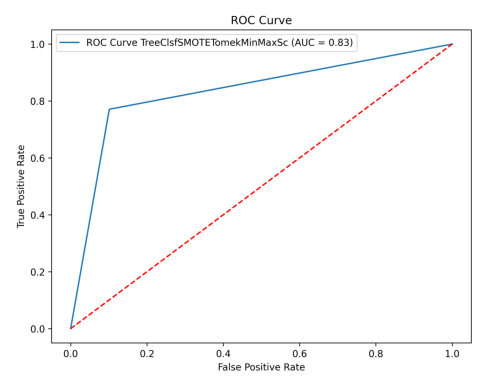

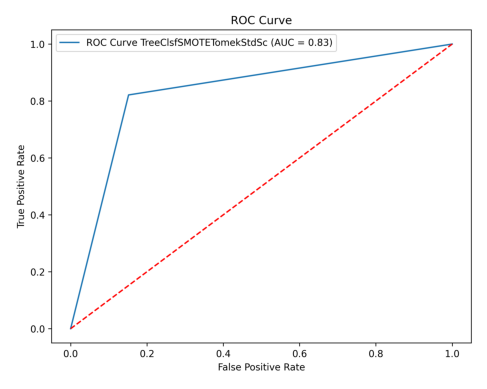

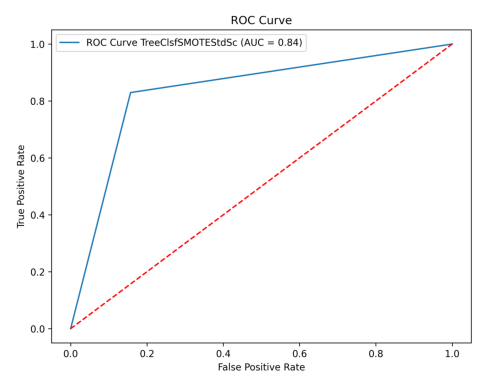

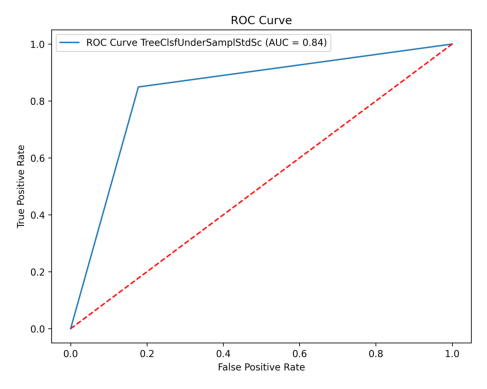

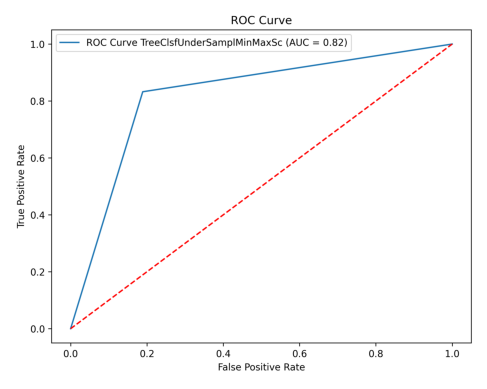

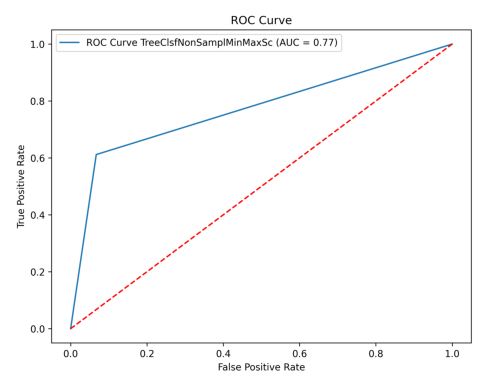

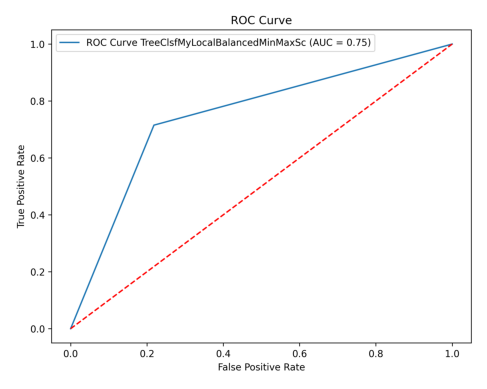

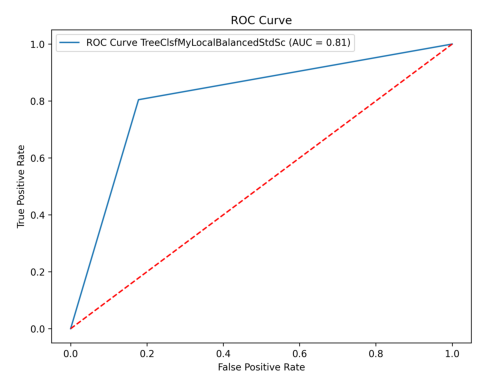

In [26]:
folder = "./tree_clsf/roc"
png_files = [f for f in os.listdir(folder) if f.endswith(".png")]

for file in png_files:
    img = Image.open(f"{folder}/{file}").convert("RGBA")
    
    plt.imshow(img)
    plt.axis("off") 
    plt.show()

------

## Случайный лес

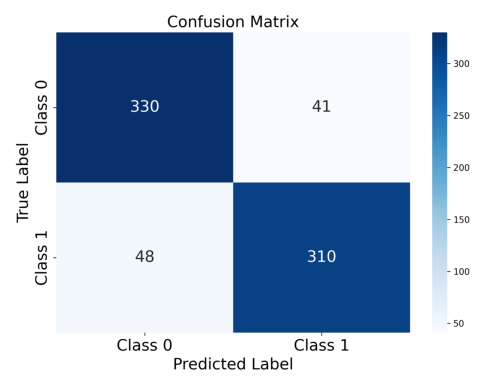

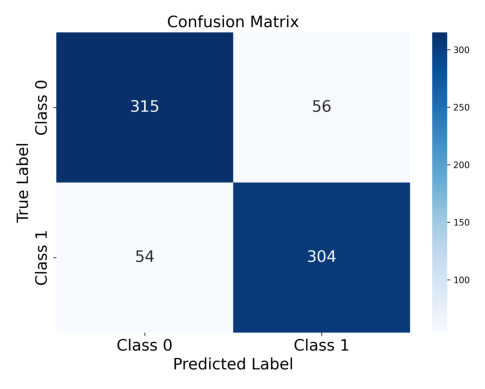

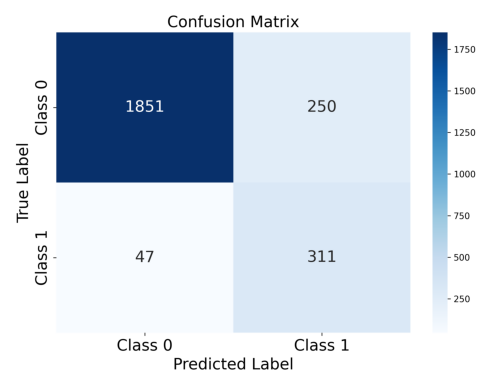

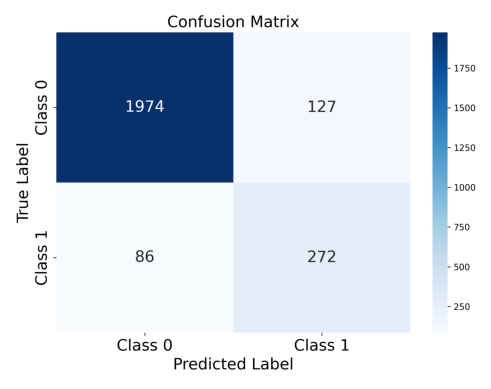

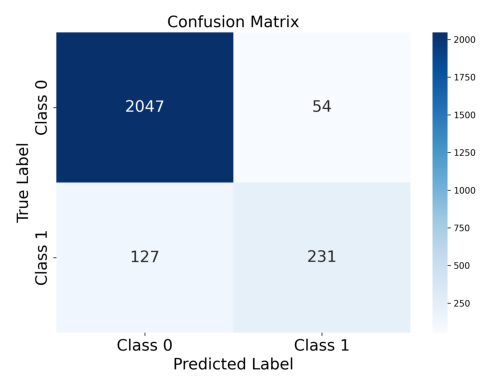

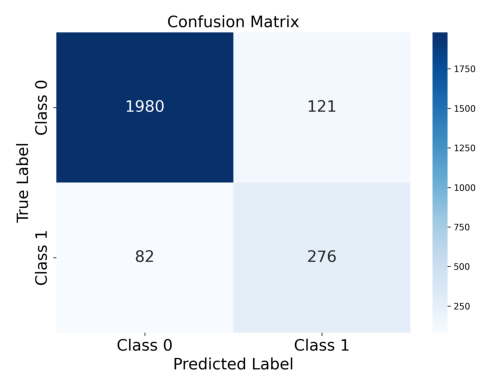

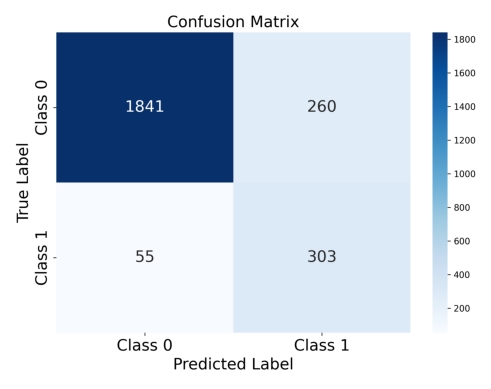

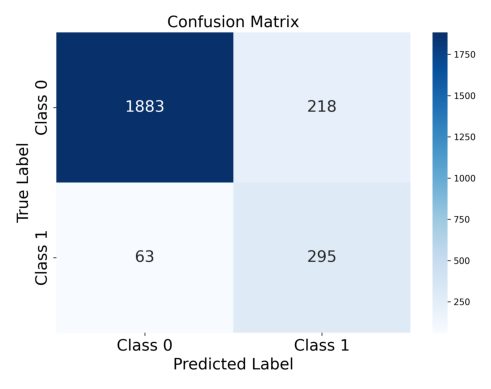

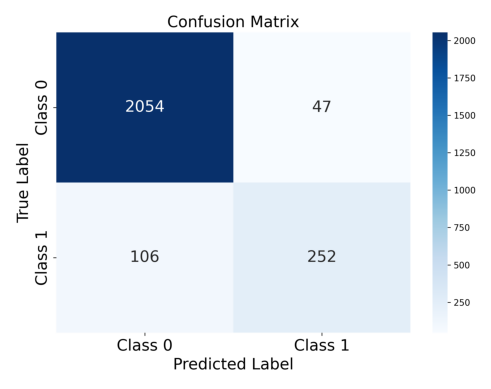

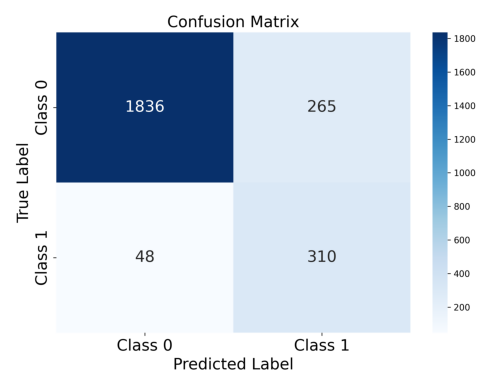

In [27]:
folder = "./forest_clsf/matrix"
png_files = [f for f in os.listdir(folder) if f.endswith(".png")]

for file in png_files:
    img = Image.open(f"{folder}/{file}").convert("RGBA")
    
    plt.imshow(img)
    plt.axis("off") 
    plt.show()

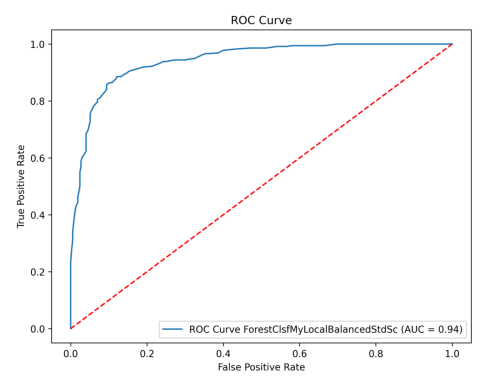

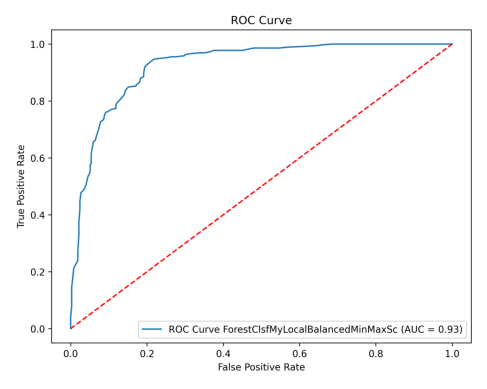

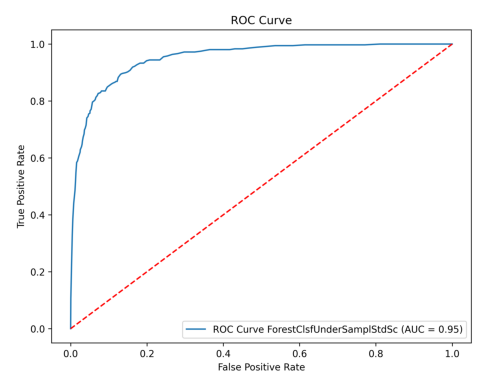

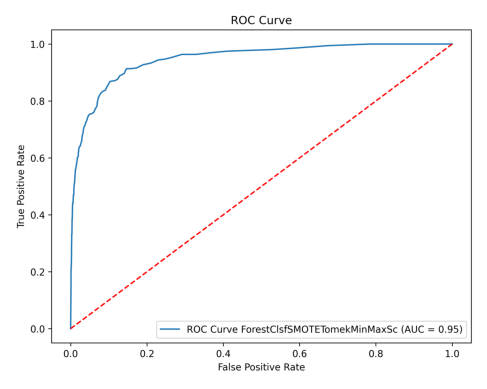

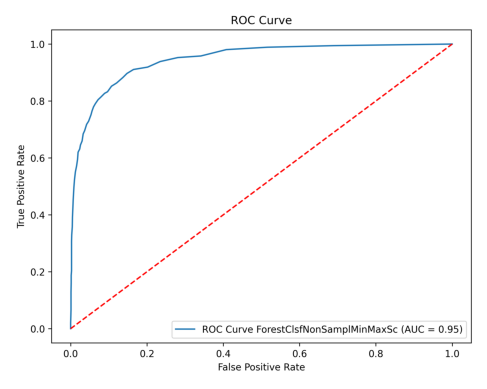

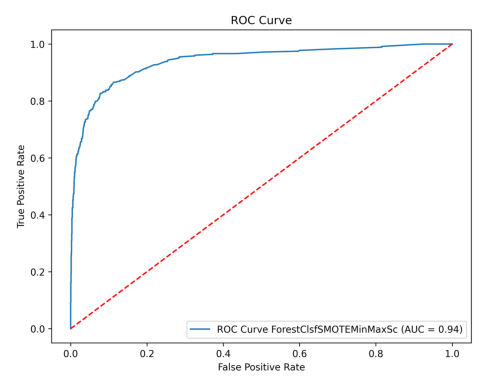

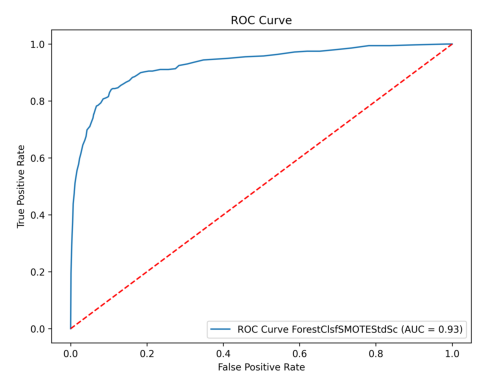

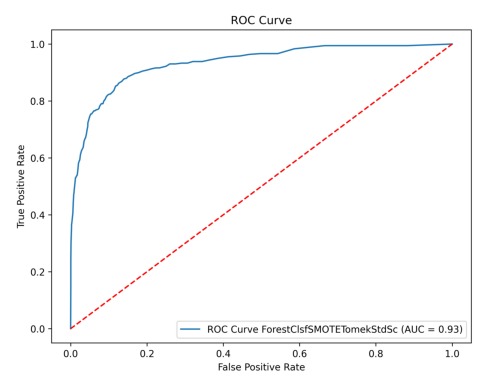

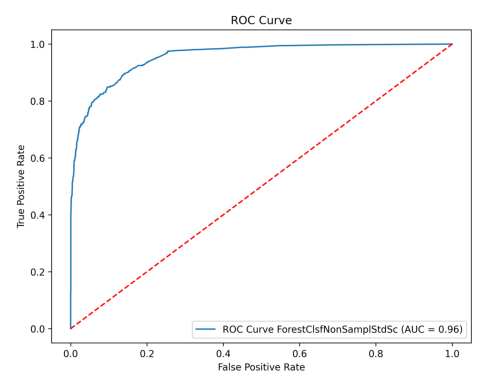

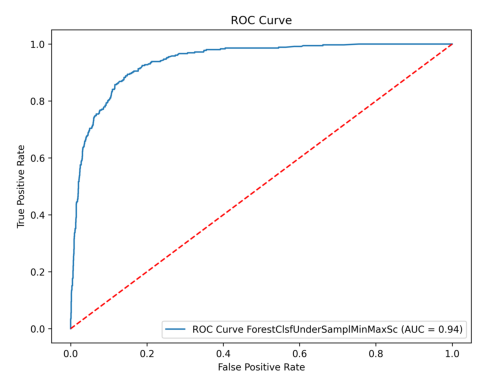

In [28]:
folder = "./forest_clsf/roc"
png_files = [f for f in os.listdir(folder) if f.endswith(".png")]

for file in png_files:
    img = Image.open(f"{folder}/{file}").convert("RGBA")
    
    plt.imshow(img)
    plt.axis("off") 
    plt.show()

------

## Метод ближайших соседей

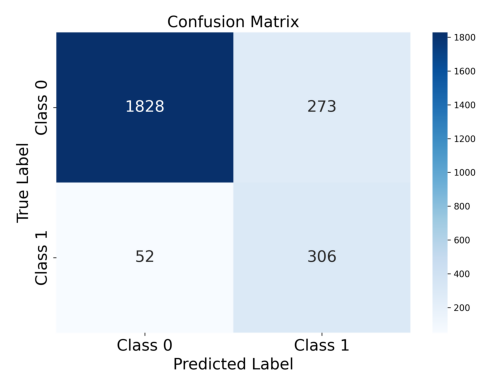

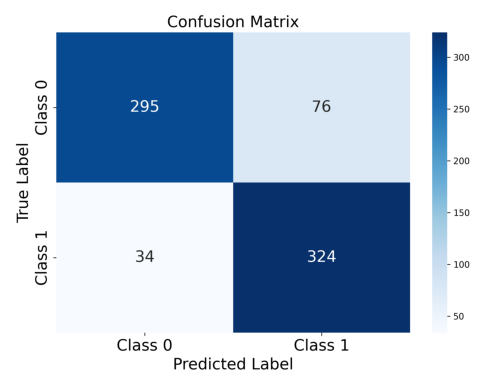

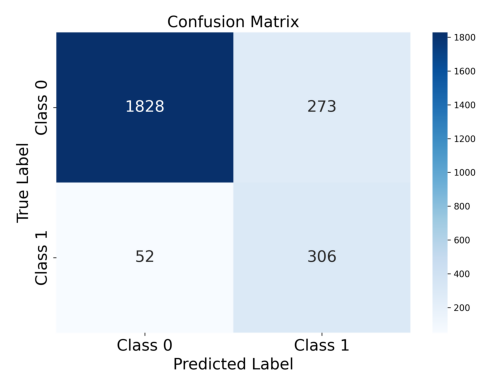

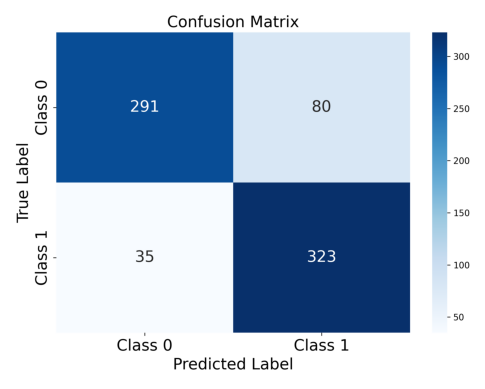

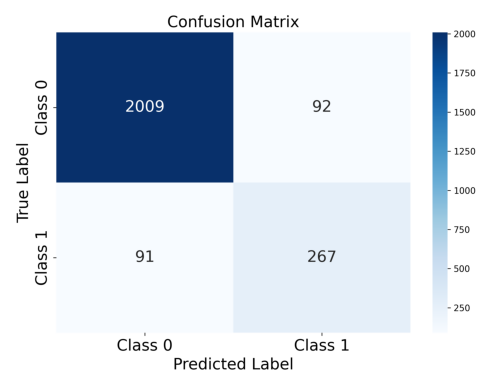

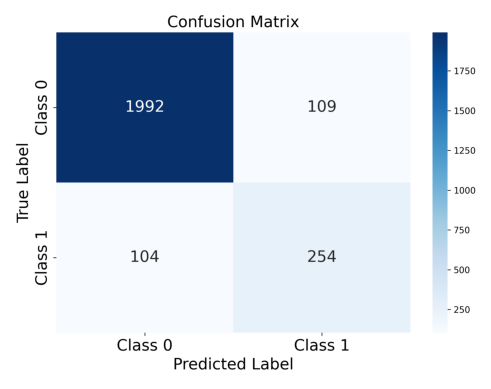

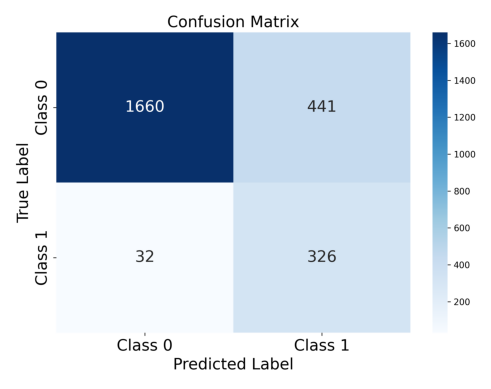

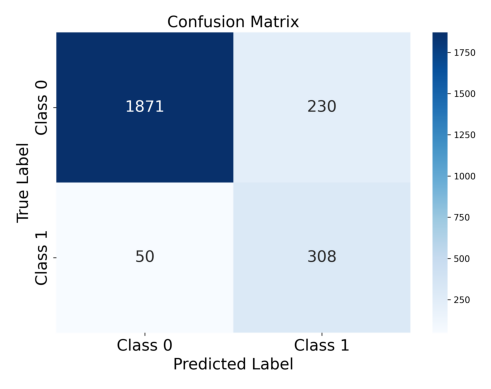

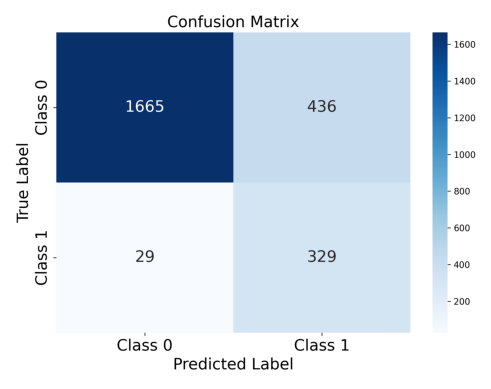

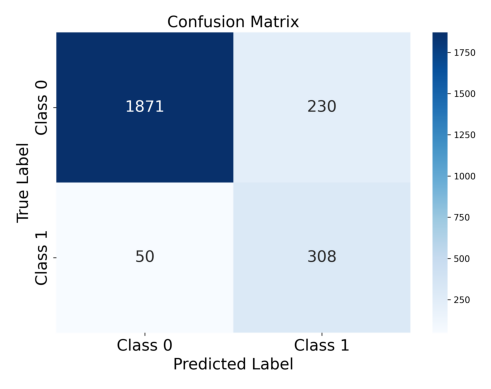

In [29]:
folder = "./knn_clsf/matrix"
png_files = [f for f in os.listdir(folder) if f.endswith(".png")]

for file in png_files:
    img = Image.open(f"{folder}/{file}").convert("RGBA")
    
    plt.imshow(img)
    plt.axis("off") 
    plt.show()

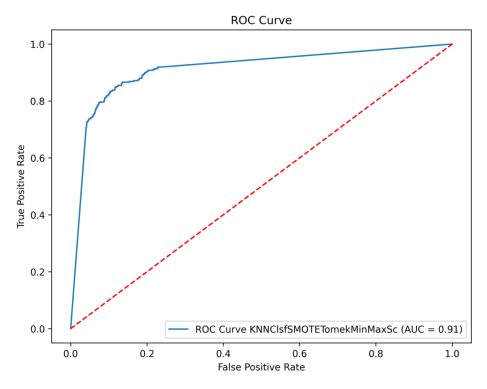

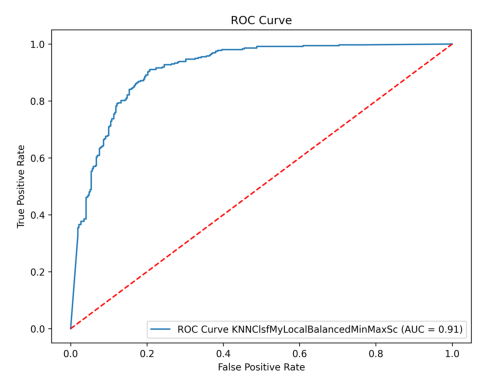

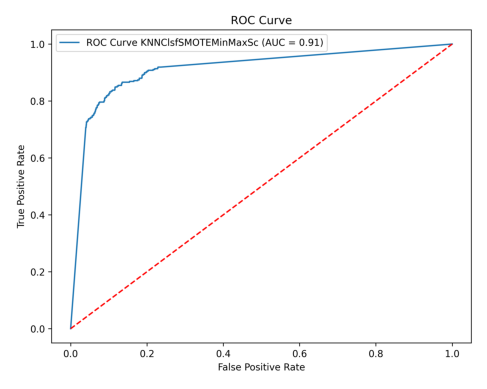

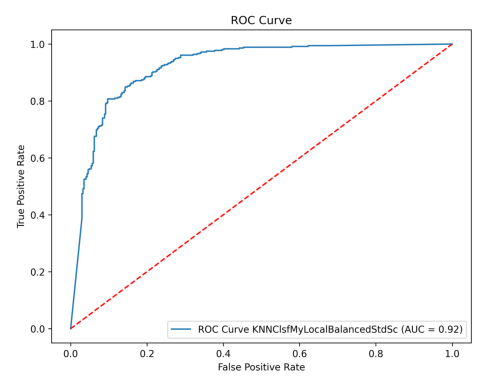

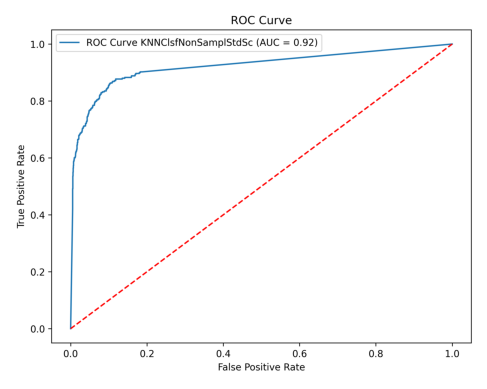

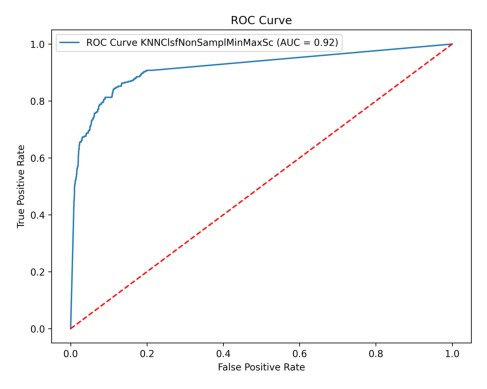

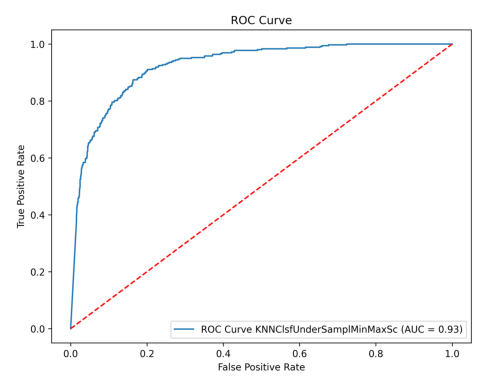

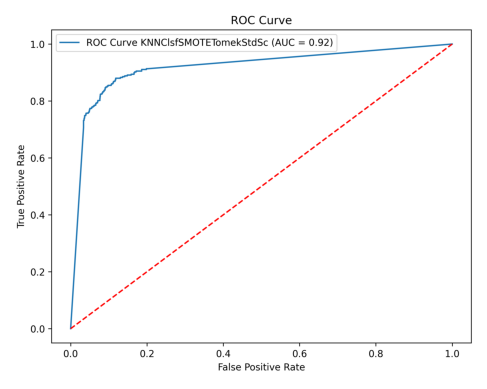

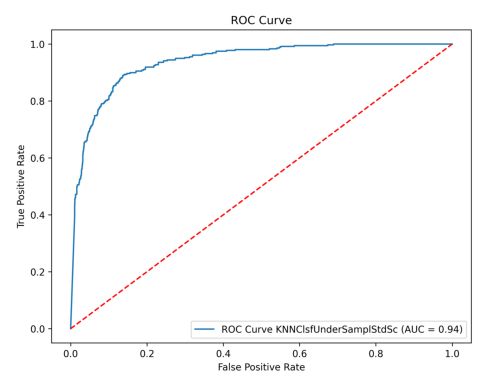

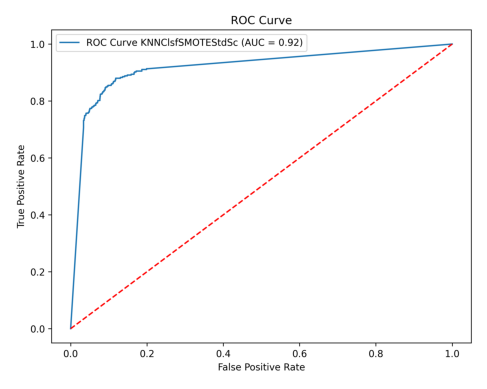

In [30]:
folder = "./knn_clsf/roc"
png_files = [f for f in os.listdir(folder) if f.endswith(".png")]

for file in png_files:
    img = Image.open(f"{folder}/{file}").convert("RGBA")
    
    plt.imshow(img)
    plt.axis("off") 
    plt.show()

## Задания:

1. Ответьте на вопрос: что такое "сбалансированная выборка" и "несбалансированная выборка"?

2. Ответьте на вопрос: какой из основных показателей качества классификационных моделей следует использовать для оценки предсказательной способности модели, в случае, если выборка несбалансирована? Почему?


1. **Сбалансированная выборка** - это выборка, в которой классы (или категории) данных представлены примерно в равных пропорциях.
2. **Несбалансированная выборка** - это выборка, в которой один или несколько классов представлены значительно меньше (или больше), чем другие.

3. * Balanced Accuracy лучше подходит, когда нужно учесть оба класса равномерно, особенно в задачах, где классы неравнозначны, но важно хорошо предсказывать оба.

    * F1-мера акцентируется на положительном классе и лучше подходит, если задача требует максимального качества предсказания редкого класса (например, обнаружение болезней).